## Libraries 📖

In [20]:
import pandas as pd
import numpy as np
import pickle
import dill
import json

import lime
from lime import lime_tabular

import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdMolDraw2D

import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import GCNConv, Sequential as GraphSequential
import torch.nn.functional as F

from IPython.display import SVG
import matplotlib
import matplotlib.cm as cm

from sklearn import metrics

np.random.seed(1234)

# Graph Convolutional Neural Network

## Featurizer 🧪

In [2]:
# Feauterizer from course "Machine Learning in Drug Design" at Jagiellonian University, Kraków, Poland.

class Featurizer:
    def __init__(self, y_column, **kwargs):
        self.y_column = y_column
        self.__dict__.update(kwargs)
    
    def __call__(self, df):
        raise NotImplementedError()

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise ValueError("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
        

class GraphFeaturizer(Featurizer):
    def __call__(self, smiles):
        graphs = []
        mol = Chem.MolFromSmiles(smiles)

        edges = []
        for bond in mol.GetBonds():
            edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
            edges.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])
        edges = np.array(edges)

        nodes = []
        for atom in mol.GetAtoms():
            results = one_of_k_encoding_unk(
                atom.GetSymbol(),
                [
                    'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Unknown'
                ]
            ) + one_of_k_encoding(
                atom.GetDegree(),
                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
            ) + one_of_k_encoding_unk(
                atom.GetImplicitValence(),
                [0, 1, 2, 3, 4, 5, 6]
            ) + [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + one_of_k_encoding_unk(
                atom.GetHybridization(),
                [
                    Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                    Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                    Chem.rdchem.HybridizationType.SP3D2
                ]
            ) + [atom.GetIsAromatic()] + one_of_k_encoding_unk(
                atom.GetTotalNumHs(),
                [0, 1, 2, 3, 4]
            )
            nodes.append(results)

        nodes = np.array(nodes)
            
        graphs.append((nodes, edges.T))
        return graphs

## Model 

In [5]:
class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(GraphNeuralNetwork, self).__init__()
        torch.manual_seed(42)
        self.final_conv_acts = None
        self.final_conv_grads = None

        self.conv1 = GCNConv(42, 100)
        self.conv2 = GCNConv(100, 400)
        self.conv3 = GCNConv(400, 200)
        self.conv4 = GCNConv(200, 100)

        self.out = nn.Linear(100, 50)
        self.out2 = nn.Linear(50, 1)
    
    def activations_hook(self, grad):
        self.final_conv_grads = grad

    def forward(self, x, edge_index, batch_index):
        out = self.conv1(x, edge_index)
        out = F.relu(out)
        out = self.conv2(out, edge_index)
        out = F.relu(out)
        out = self.conv3(out, edge_index)
        out = F.relu(out)
        out = F.dropout(out, training=self.training) #p=0.5
        
        with torch.enable_grad():
            self.final_conv_acts = self.conv4(out, edge_index)
        self.final_conv_acts.register_hook(self.activations_hook)
        
        out = F.relu(self.final_conv_acts)
        out = gap(out, batch_index) # global_mean_pool
        out = self.out(out)
        out = F.relu(out)
        out = self.out2(out)

        return out

In [6]:
model = GraphNeuralNetwork()
model.load_state_dict(torch.load('../../models/solubility_graph_model_0.pt')) # best model
model.eval()

GraphNeuralNetwork(
  (conv1): GCNConv(42, 100)
  (conv2): GCNConv(100, 400)
  (conv3): GCNConv(400, 200)
  (conv4): GCNConv(200, 100)
  (out): Linear(in_features=100, out_features=50, bias=True)
  (out2): Linear(in_features=50, out_features=1, bias=True)
)

## GradCam 

In [7]:
def grad_cam(final_conv_acts, final_conv_grads):
    node_heat_map = []
    alphas = torch.mean(final_conv_grads, axis=0)
    for n in range(final_conv_acts.shape[0]):
        node_heat = F.relu(alphas @ final_conv_acts[n]).item()
        node_heat_map.append(node_heat)
    return node_heat_map

## Predict and inteprete

In [8]:
def draw_gradcam(atom_weights, mol):
    atom_weights = np.array(atom_weights)
    if (atom_weights > 0.).any():
        atom_weights = atom_weights / atom_weights.max() / 2

    if len(atom_weights) > 0:
        norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
        cmap = cm.get_cmap('bwr')
        plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
        atom_colors = {
            i: plt_colors.to_rgba(atom_weights[i]) for i in range(len(atom_weights))
        }
        highlight_kwargs = {
            'highlightAtoms': list(range(len(atom_weights))),
            'highlightBonds': [],
            'highlightAtomColors': atom_colors
        }

    d = rdMolDraw2D.MolDraw2DSVG(500, 500) 
    rdMolDraw2D.PrepareAndDrawMolecule(d, mol, **highlight_kwargs)
    d.FinishDrawing()
    svg = d.GetDrawingText()
    svg = svg.replace('svg:', '')
    return SVG(svg)

Prediction: 3.6310346


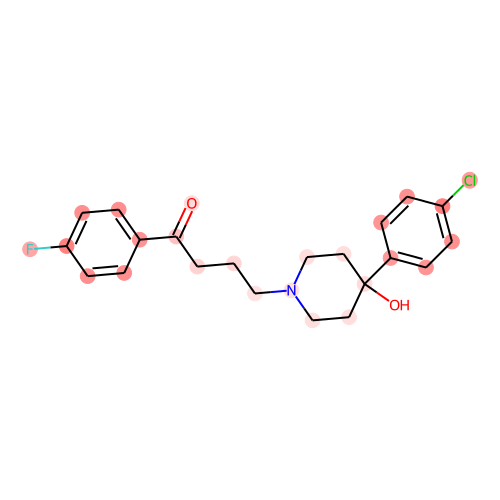

In [9]:
example_smiles = 'O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1'
mol = Chem.MolFromSmiles(example_smiles)

featurizer = GraphFeaturizer(y_column='solubility')
graph = featurizer(example_smiles)
X, E = graph[0]

data = Data(x=torch.FloatTensor(X), edge_index=torch.LongTensor(E))

x, edge_index, batch = data.x, data.edge_index, data.batch

pred = model(x, edge_index, torch.zeros(x.shape[0], dtype=torch.int64))
pred.backward()
print("Prediction:", pred.data.cpu().numpy()[0][0]) 

atom_weights = grad_cam(model.final_conv_acts, model.final_conv_grads)    
    
draw_gradcam(atom_weights, mol)

## Graph model predictions

In [14]:
df_test_smiles = pd.read_csv("../../data/train/solubility/solub_smiles_test.csv")
X_test_smiles = df_test_smiles['smiles']

graph_predictions = []

for smiles in X_test_smiles:
    featurizer = GraphFeaturizer(y_column='pIC50')
    graph = featurizer(smiles)
    X, E = graph[0]
    data = Data(x=torch.FloatTensor(X), edge_index=torch.LongTensor(E))

    x, edge_index, batch = data.x, data.edge_index, data.batch

    pred = model(x, edge_index, torch.zeros(x.shape[0], dtype=torch.int64))
    pred.backward()
    
    graph_predictions.append(pred.data.cpu().numpy()[0][0])
    
graph_predictions = np.array(graph_predictions) 

In [15]:
print_evaluate(y_test, graph_predictions)

MAE: 0.6096902416786479
MSE: 0.5928870708902692
RMSE: 0.7699916044284308
R2 Square 0.35232360173343646 



# Models comparasion

In [10]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## MACCS keys model

Histogram-based Gradient Boosting Regression Tree

In [32]:
df_test = pd.read_csv("../../data/train/solubility/solub_maccs_test.csv")
X_test_maccs = df_test.loc[:, df_test.columns != 'solubility']
y_test_maccs = df_test['solubility']

In [12]:
maccs_model = pickle.load(open('../../models/solub_maccs_hist_model.pkl', 'rb'))

In [28]:
maccs_predictions  = maccs_model.predict(X_test_maccs)

In [29]:
print_evaluate(y_test, maccs_predictions)

MAE: 0.6359305898979593
MSE: 0.6263361979663005
RMSE: 0.7914140496391888
R2 Square 0.31578340510335323 



### Combination of models

![Final](images/final.png)

In [17]:
average_predictions = (maccs_predictions + graph_predictions)/2
print_evaluate(y_test, average_predictions)

MAE: 0.5904022168938496
MSE: 0.5336890878866991
RMSE: 0.7305402712285608
R2 Square 0.41699213356501297 



## Pubchem fingerprint model

In [33]:
df_test = pd.read_csv("../../data/train/solubility/solub_pubchem_test.csv")
X_test_pubchem = df_test.loc[:, df_test.columns != 'solubility']
y_test_pubchem = df_test['solubility']

In [34]:
with open('../../pubchem_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_test_pubchem = X_test_pubchem[idxs['solubility']]

In [35]:
pubchem_model = pickle.load(open('../../models/solub_pubchem_rf_model.pkl', 'rb'))

In [36]:
pubchem_predictions  = pubchem_model.predict(X_test_pubchem)

In [37]:
print_evaluate(y_test, pubchem_predictions)

MAE: 0.6272015280653621
MSE: 0.5871693299042482
RMSE: 0.7662697500908203
R2 Square 0.3585697252700595 



### Combination of models

In [38]:
average_predictions = (pubchem_predictions + graph_predictions)/2
print_evaluate(y_test, average_predictions)

MAE: 0.5910010204783124
MSE: 0.5223089537039441
RMSE: 0.7227094531718429
R2 Square 0.42942391810065705 

